In [54]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import pickle as pkl
from collections import defaultdict

from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

In [2]:
PATH_TO_DATA = ('./data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
site_dict = pkl.load(open('./data/site_dic.pkl', 'rb'))
site_dict_inv = defaultdict(str, [(v, k) for (k, v) in site_dict.items()])

In [4]:
train_df.sort_values(by='time1', inplace=True)

In [5]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [151]:
X = train_df.drop('target', axis=1)
test = test_df.copy()

In [7]:
y = train_df['target']

### preprocessing

In [152]:
times = ['time%s' % i for i in np.arange(1, 11)]
sites = ['site%s' % i for i in np.arange(1, 11)]

In [153]:
alice_sites_count = defaultdict(int)
for row in tqdm_notebook(train_df[train_df['target'] == 1][sites].fillna(0).values):
    for site in row:
        if site != 0:
            alice_sites_count[int(site)] += 1
alice_sites_all = sorted([(k, v) for (k, v) in alice_sites_count.items()], key=lambda x: x[1], reverse=True)

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

In [154]:
X[times] = X[times].fillna(0).apply(pd.to_datetime)
test[times] = test[times].fillna(0).apply(pd.to_datetime)

X[sites] = X[sites].fillna(0).astype('int')
test[sites] = test[sites].fillna(0).astype('int')

In [155]:
X['all_sites'] = X[sites].apply(lambda row: ' '.join(str(r) for r in row), axis=1)
test['all_sites'] = test[sites].apply(lambda row: ' '.join(str(r) for r in row), axis=1)

In [188]:
site_name = [site + '_name' for site in sites]

def is_ip(ip):
    spl = ip.split('.')
    if len(spl) != 4:
        return False
    for s in spl:
        if not s.isdigit():
            return False
    return True

def convert(x):
    if is_ip(x):
        return x
    elif x != '':
        return x.split('.')[-2]
    else:
        return '-'

for site in tqdm_notebook(sites):
    X[site + '_name'] = X[site].apply(lambda x: site_dict_inv[x].replace('.', ' '))
    test[site + '_name'] = test[site].apply(lambda x: site_dict_inv[x].replace('.', ' '))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [189]:
X['all_sites_name'] = X[site_name].apply(lambda row: ' '.join(str(r) for r in row), axis=1)
test['all_sites_name'] = test[site_name].apply(lambda row: ' '.join(str(r) for r in row), axis=1)

### tf-idf

In [156]:
tf_idf = TfidfVectorizer(ngram_range=(1, 7), max_features=100000, max_df=.5)
tf_idf.fit(X['all_sites'])
X_tfidf = tf_idf.transform(X['all_sites'])
test_tfidf = tf_idf.transform(test['all_sites'])

In [190]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features=200000)
tf_idf.fit(X['all_sites_name'])
X_tfidf = tf_idf.transform(X['all_sites_name'])
test_tfidf = tf_idf.transform(test['all_sites_name'])

### bag of site

In [13]:
cv = CountVectorizer(ngram_range=(1, 2), max_features=100000)
cv.fit(X['all_sites'])
X_cv = cv.transform(X['all_sites'])
test_cv = cv.transform(test['all_sites'])

In [53]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=200000)
cv.fit(X['all_sites_name'])
X_cv = cv.transform(X['all_sites_name'])
test_cv = cv.transform(test['all_sites_name'])

### feature engineering

In [157]:
hours = ['hour%s' % i for i in np.arange(1, 11)]
X[hours] = X[times].apply(lambda x: [h.hour for h in x], axis=1)
test[hours] = test[times].apply(lambda x: [h.hour for h in x], axis=1)

In [158]:
def get_duration(row):
    zero = np.datetime64('1970-01-01T00:00:00.000000000')
    cor = [r for r in row if r != zero]
    diff = (cor[-1] - cor[0])
    return diff
    
X['duration'] = X[times].apply(lambda x: get_duration(x).total_seconds(), axis=1)
test['duration'] = test[times].apply(lambda x: get_duration(x).total_seconds(), axis=1)

In [159]:
X['weekday'] = X['time1'].apply(lambda x: x.weekday())
test['weekday'] = test['time1'].apply(lambda x: x.weekday())

In [160]:
alice_top_sites = [i[0] for i in alice_sites_all][:20]

alice_sites = ['site_%s' % site for site in alice_top_sites]

for site in tqdm_notebook(alice_top_sites):
    X['site_%s' % site] = X[sites].apply(lambda x: any([xi == site for xi in x]), axis=1).astype(int)
    test['site_%s' % site] = test[sites].apply(lambda x: any([xi == site for xi in x]), axis=1).astype(int)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [170]:
def get_times(df, site):
    site = int(site)
    times = ['time%s' % i for i in np.arange(1, 11)]
    sites = ['site%s' % i for i in np.arange(1, 11)]
    sit_val = df[sites].values
    tim_val = df[times].values
    res = [pd.to_datetime(ts[np.argwhere(ss == site)][0][0]).hour if site in ss else 25
           for (ss, ts) in zip(sit_val, tim_val)]
    return res

alice_sites_time = ['site_%s_time' % site for site in alice_top_sites]

for site in tqdm_notebook(alice_sites):
    X['site_%s_time' % site.replace('site_', '')] = get_times(X, site.replace('site_', ''))
    test['site_%s_time' % site.replace('site_', '')] = get_times(test, site.replace('site_', ''))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [162]:
X['YYYYMM'] = X['time1'].apply(lambda x: x.year * 100 + x.month)
test['YYYYMM'] = test['time1'].apply(lambda x: x.year * 100 + x.month)

In [163]:
def is_worktime(hour, weekday):
    if weekday == 6:
        return 0
    if (hour >= 9 and hour <= 13) or (hour >= 15 and hour <= 18):
        return 1
    return 0

X['worktime'] = X['time1'].apply(lambda x: is_worktime(x.hour, x.weekday()))
test['worktime'] = test['time1'].apply(lambda x: is_worktime(x.hour, x.weekday()))

In [164]:
def is_holiday(month):
    if month in (9, 10, 11, 12, 1, 2, 3, 4, 5):
        return 0
    else:
        return 1
    
X['holiday'] = X['time1'].apply(lambda x: is_holiday(x.month))
test['holiday'] = test['time1'].apply(lambda x: is_holiday(x.month))

In [165]:
def get_time_diff(row): 
    time_length = row.shape[0] - 1 
    time_diff = [0] * time_length 
    i = 0 
    while (i < time_length) and pd.notnull(row[i+1]): 
        time_diff[i] = (row[i + 1] - row[i]) / np.timedelta64(1, 's')
        i += 1 
    return time_diff

time_diffs = ['time_diff%s' % i for i in np.arange(1,10)] 

X_time_diff = []
for row in tqdm_notebook(X[times].values):
    X_time_diff.append(get_time_diff(row))
X_time_diff = np.log1p(np.array(X_time_diff).astype(float))

for ind, time_diff in tqdm_notebook(enumerate(time_diffs)):
    X[time_diff] = X_time_diff[:, ind]
    
test_time_diff = []
for row in tqdm_notebook(test[times].values):
    test_time_diff.append(get_time_diff(row))
test_time_diff = np.log1p(np.array(test_time_diff).astype(float))

for ind, time_diff in tqdm_notebook(enumerate(time_diffs)):
    test[time_diff] = test_time_diff[:, ind]
    
X.fillna(0, inplace=True)
test.fillna(0, inplace=True)

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [166]:
X['unique'] = X[sites].apply(lambda x: len(np.unique([i for i in x if i > 0])), axis=1)
test['unique'] = test[sites].apply(lambda x: len(np.unique([i for i in x if i > 0])), axis=1)

In [167]:
X

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,unique
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,0.000000,7.487174,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,6
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,5
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,6
242171,952,2013-01-12 08:50:22,947,2013-01-12 08:50:23,953,2013-01-12 08:50:23,946,2013-01-12 08:50:23,947,2013-01-12 08:50:24,...,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,5
57157,953,2013-01-12 08:50:25,947,2013-01-12 08:50:26,946,2013-01-12 08:50:26,953,2013-01-12 08:50:26,955,2013-01-12 08:50:26,...,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,5
240201,946,2013-01-12 08:50:28,947,2013-01-12 08:50:28,954,2013-01-12 08:50:28,953,2013-01-12 08:50:29,946,2013-01-12 08:50:29,...,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,6
210686,946,2013-01-12 08:50:31,956,2013-01-12 08:50:32,946,2013-01-12 08:50:32,946,2013-01-12 08:50:33,955,2013-01-12 08:50:33,...,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,0.693147,0.693147,0.000000,5


### Stacking

In [178]:
ohe_columns = hours + ['weekday']
numeric_columns = ['duration', 'YYYYMM', 'unique'] + time_diffs
binary_columns = alice_sites + ['worktime', 'holiday']

In [179]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[ohe_columns])
X_ohe = ohe.transform(X[ohe_columns])
test_ohe = ohe.transform(test[ohe_columns])

ss = StandardScaler()
ss.fit(X[numeric_columns].append(test[numeric_columns]))
X_numeric = ss.transform(X[numeric_columns])
test_numeric = ss.transform(test[numeric_columns])

X_binary = X[binary_columns]
test_binary = test[binary_columns]

In [191]:
X_all = hstack([X_tfidf, X_binary, X_numeric, X_ohe]).tocsr()
test_all = hstack([test_tfidf, test_binary, test_numeric, test_ohe]).tocsr()

### Validating

In [83]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.7):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # lr = SGDClassifier(random_state=seed, n_jobs=-1, loss='log').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred_val = lr.predict_proba(X[idx:, :])[:, 1]
    y_pred_train = lr.predict_proba(X[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [192]:
%%time
print(get_auc_lr_valid(X_all, y))

(0.9903599100196809, 0.9597873965923136)
CPU times: user 26.4 s, sys: 1.19 s, total: 27.6 s
Wall time: 14 s


In [36]:
%%time
split = TimeSeriesSplit(10)
cv = cross_val_score(LogisticRegression(C=1.0, random_state=7, n_jobs=-1), X_all, y, scoring='roc_auc',
               cv=split, n_jobs=-1)
print(cv.mean())

0.8936433109695654
CPU times: user 2.84 s, sys: 200 ms, total: 3.04 s
Wall time: 50.5 s


In [194]:
train_score = []
val_score = []
cv_score = []
C = [0.01, 0.1, 1, 2, 3, 4, 5, 10, 20, 30]
for c in tqdm_notebook(C):
    # cv_score.append(cross_val_score(LogisticRegression(C=c, random_state=7, n_jobs=-1), X_all, y, scoring='roc_auc',
    #            cv=split, n_jobs=-1).mean())
    score = get_auc_lr_valid(X_all, y , C=c)
    train_score.append(score[0])
    val_score.append(score[1])

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

Text(0.5,0,'C')

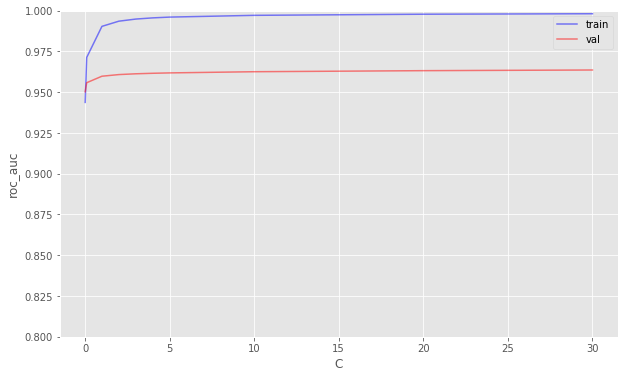

In [195]:
(fig, ax) = plt.subplots(figsize=(10, 6))
ax.plot(C, train_score, alpha=0.5, color='blue', label='train')
ax.plot(C, val_score, alpha=0.5, color='red', label='val')
# ax.plot(C, cv_score, alpha=0.5, color='green', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.8, 1])
ax.set_ylabel('roc_auc')
ax.set_xlabel('C')

In [196]:
list(zip(zip(C, train_score),\
         zip(C, val_score)))

[((0.01, 0.9437354493586565), (0.01, 0.9502489643308322)),
 ((0.1, 0.9713111646293684), (0.1, 0.9558080859941143)),
 ((1, 0.9903599100196809), (1, 0.9597873965923136)),
 ((2, 0.9935348677440715), (2, 0.9607914231656953)),
 ((3, 0.9948318324763511), (3, 0.9612779629539652)),
 ((4, 0.9955631252528839), (4, 0.9615888714372223)),
 ((5, 0.9960378420083307), (5, 0.9618213808618132)),
 ((10, 0.9971168904198789), (10, 0.9625473008758075)),
 ((20, 0.9978057654582912), (20, 0.9631926072753987)),
 ((30, 0.9981041322841833), (30, 0.9636018268911308))]

### Boosting

In [78]:
boost_columns = ['weekday'] + hours + ['duration', 'YYYYMM'] + time_diffs + alice_sites + ['worktime', 'holiday']

In [103]:
X_boost = hstack([X_binary, X_numeric, X_ohe]).tocsr()
test_boost = hstack([test_binary, test_numeric, test_ohe]).tocsr()

In [114]:
def get_auc_xgb_valid(X, y, n_iter=500, learning_rate=0.1, seed=17, ratio=0.7):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    xgb_cl = xgb.XGBClassifier(learning_rate=learning_rate, n_iter=n_iter, booster='gblinear',
                           n_jobs=-1, random_state=seed).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred_val = xgb_cl.predict_proba(X[idx:, :])[:, 1]
    y_pred_train = xgb_cl.predict_proba(X[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [117]:
%%time
print(get_auc_xgb_valid(X_boost, y, n_iter=100, learning_rate=1))

(0.888580875245357, 0.926922310564489)
CPU times: user 5.98 s, sys: 140 ms, total: 6.12 s
Wall time: 6.16 s


### fit model and make prediction

In [199]:
%%time
clf = LogisticRegression(random_state=17, n_jobs=-1, C=30)
# clf = xgb.XGBClassifier(learning_rate=0.1, n_iter=100,
#                            n_jobs=-1, random_state=17)
clf.fit(X_all, y)
test_pred = clf.predict_proba(test_all)

CPU times: user 2min 22s, sys: 5.03 s, total: 2min 27s
Wall time: 1min 13s


In [33]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [200]:
write_to_submission_file(test_pred[:, 1],
                         './submissions/tfidf1-3-text+c30.csv')